# Tutorial 2: From Perceptrons to Deep Neural Networks

## Welcome!

In this tutorial, you'll learn the fundamental challenges and solutions for training deep neural networks.

**What you'll master:**
- The vanishing gradient problem
- Activation functions (sigmoid, tanh, ReLU)
- Detecting overfitting
- Regularization techniques (L1, L2, Dropout)

**Time commitment:** 30-45mins

**Prerequisites:**
- Basic Python and PyTorch
- Understanding of neural networks
- Completed Tutorial 1 (recommended)

---

## Setup and Imports

First, let's import all the necessary modules from our tutorial package.

In [1]:
# Core libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Tutorial modules
from perceptron_to_DNN_tutorial.MultiLayerPerceptron import MultiLayerPerceptron
from perceptron_to_DNN_tutorial.train import (
    train_model_with_gradient_tracking,
    train_model_with_validation_tracking
)
from perceptron_to_DNN_tutorial.utils import (
    generate_high_order_polynomial_data,
    FeatureNormalizer
)
from perceptron_to_DNN_tutorial.plotting import (
    plot_gradient_flow,
    plot_layer_gradient_norms,
    plot_regularization_comparison,
    plot_results
)

# Initialize logger
import logging
from perceptron_to_DNN_tutorial.logger import configure_logging
configure_logging()
logger = logging.getLogger(__name__)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

All imports successful!
PyTorch version: 2.10.0+cpu
Device: cpu


## Configuration

Let's set up our experimental parameters. These control:
- Network architecture (depth and width)
- Data properties (polynomial complexity, noise)
- Training hyperparameters

**Note:** Feel free to modify these later to see how results change!

In [2]:
# ========================================
# CONFIGURATION
# ========================================

# Network Architecture
# This is a DEEP network: 10 layers total (1 input → 9 hidden → 1 output)
architecture_deep = [1, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1]

# Data Generation Parameters
poly_order = 9           # High-order polynomial (complex function)
coeffs_true = [10.0, 0.5, -0.04, 0.015, -0.001, -0.0003, 0.000055, -0.000005, -1e-7, 2e-8]
n_samples_train = 200    # Training set size
n_samples_valid = 200    # Validation set size  
n_samples_test = 200     # Test set size
noise_std = 2.5          # Noise level in data
x_min = 0                # Input range start
x_max = 10               # Input range end

# Training Hyperparameters
num_epochs = 10000       # Training iterations (for vanishing gradient demo)
learning_rate = 0.005    # Step size for gradient descent

# Activation functions to test
activations_to_test = ['sigmoid', 'tanh', 'relu']

# Regularization parameters
lambda_l2 = 0.01         # L2 regularization strength
lambda_l1 = 0.001        # L1 regularization strength
dropout_rate = 0.1       # Dropout probability

print("\n" + "="*70)
print(" CONFIGURATION")
print("="*70)
print(f"Polynomial order: {poly_order}")
print(f"True coefficients: {coeffs_true}")
print(f"Training samples: {n_samples_train}")
print(f"Validation samples: {n_samples_valid}")
print(f"Test samples: {n_samples_test}")
print(f"Network architecture: {' → '.join(map(str, architecture_deep))}")
print(f"Activations to test: {activations_to_test}")
print(f"Training epochs (gradient demo): {num_epochs}")
print("="*70)


 CONFIGURATION
Polynomial order: 9
True coefficients: [10.0, 0.5, -0.04, 0.015, -0.001, -0.0003, 5.5e-05, -5e-06, -1e-07, 2e-08]
Training samples: 200
Validation samples: 200
Test samples: 200
Network architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
Activations to test: ['sigmoid', 'tanh', 'relu']
Training epochs (gradient demo): 10000


---

# Part 1: The Vanishing Gradient Problem

## What is it?

In deep networks, gradients can shrink exponentially as they backpropagate through layers:

$$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial h_9} \cdot \frac{\partial h_9}{\partial h_8} \cdot \ldots \cdot \frac{\partial h_2}{\partial h_1} \cdot \frac{\partial h_1}{\partial W_1}$$

With sigmoid/tanh, each derivative can be < 1, so the product **vanishes** (approaches 0).

## Why does it matter?

- Early layers get **tiny gradients** → learn very slowly
- Network becomes effectively **shallow**
- Can't leverage the power of depth

## What's the solution?

**ReLU activation!** ReLU'(x) = 1 for x > 0, preventing gradient decay.

Let's see this in action!

## Step 1.1: Generate Datasets

We'll create three separate datasets:
- **Training**: Used to update weights
- **Validation**: Used to monitor overfitting
- **Test**: Used for final evaluation

**Key principle:** Use different random seeds so datasets are truly independent!

In [3]:
print("\n" + "="*70)
print(" PART 1: VANISHING GRADIENT PROBLEM")
print("="*70)

print("\n[STEP 1.1] Generating train/validation/test datasets...")

# Generate training data
x_train, y_train = generate_high_order_polynomial_data(
    coeffs_true=coeffs_true,
    poly_order=poly_order,
    n_samples=n_samples_train,
    x_min=x_min,
    x_max=x_max,
    noise_std=noise_std,
    seed=42
)

# Generate validation data (different seed!)
x_valid, y_valid = generate_high_order_polynomial_data(
    coeffs_true=coeffs_true,
    poly_order=poly_order,
    n_samples=n_samples_valid,
    x_min=x_min,
    x_max=x_max,
    noise_std=noise_std,
    seed=123
)

# Generate test data (different seed!)
x_test, y_test = generate_high_order_polynomial_data(
    coeffs_true=coeffs_true,
    poly_order=poly_order,
    n_samples=n_samples_test,
    x_min=x_min,
    x_max=x_max,
    noise_std=noise_std,
    seed=456
)

print(f"✓ Training: {len(x_train)} samples, y range [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"✓ Validation: {len(x_valid)} samples, y range [{y_valid.min():.2f}, {y_valid.max():.2f}]")
print(f"✓ Test: {len(x_test)} samples, y range [{y_test.min():.2f}, {y_test.max():.2f}]")


 PART 1: VANISHING GRADIENT PROBLEM

[STEP 1.1] Generating train/validation/test datasets...
✓ Training: 200 samples, y range [-2.47, 17.12]
✓ Validation: 200 samples, y range [-0.88, 17.32]
✓ Test: 200 samples, y range [-2.13, 17.39]


## Step 1.2: Normalize Features

Neural networks work best with normalized inputs. We'll normalize to the range [-1, 1].

**Critical:** Use training statistics to normalize ALL datasets (train, val, test)!

In [4]:
print("\n[STEP 1.2] Normalizing features...")

# Fit normalizer on training data only
normalizer = FeatureNormalizer(method='symmetric')
x_t = normalizer.fit_transform(x_train)
y_t = y_train

# Apply same normalization to validation and test
x_valid_norm = normalizer.transform(x_valid)
x_test_norm = normalizer.transform(x_test)

print(f"✓ Features normalized to [{x_t.min():.2f}, {x_t.max():.2f}] using training statistics")
print(f"  (Validation and test use same normalization as training)")


[STEP 1.2] Normalizing features...
2026-02-23 23:50:55,818 | INFO     | perceptron_to_DNN_tutorial.utils:233 | Fitted symmetric normalizer: mean=None, std=None, min=0.0, max=10.0
✓ Features normalized to [-1.00, 1.00] using training statistics
  (Validation and test use same normalization as training)


## Step 1.3: Train with Different Activations

Now we'll train **deep networks** (9 hidden layers) with three activation functions:

1. **Sigmoid**: sigmoid(x) = 1/(1+e^(-x)), derivative ∈ (0, 0.25]
2. **Tanh**: tanh(x), derivative ∈ (0, 1]
3. **ReLU**: max(0, x), derivative = 1 for x > 0

We'll track gradients at each layer to see the vanishing gradient problem in action!

**This will take a few minutes** .

In [5]:
print("\n[STEP 1.3] Training deep networks with different activations...")
print("This demonstrates the vanishing gradient problem!\n")

# Store training histories
gradient_histories = {}

for activation in activations_to_test:
    print(f"\n--- Training with {activation.upper()} activation ---")
    
    # Create model
    #model = ResidualMLP(
    model = MultiLayerPerceptron(
        layer_sizes=architecture_deep,
        activation=activation,
        use_batch_norm=True
    )
    
    # Train with gradient tracking and per-sample distributions
    trained_model, history = train_model_with_gradient_tracking(
        model=model,
        x_train=x_t,
        y_train=y_t,
        x_valid=x_valid_norm,
        y_valid=y_valid,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        reg_type='none',  # No regularization
        print_every=500,
        verbose=True,
        track_gradients=True,
        track_per_sample_gradients=False  # For distribution plots
    )
    
    # Store full history (includes per-sample gradients)
    gradient_histories[activation] = history
    
    # Analyze final gradients
    final_grads = history['gradient_norms'][-1]
    layer_names = [name for name in final_grads.keys() if 'weight' in name]
    
    print(f"\nFinal gradient magnitudes ({activation}):")
    for layer_name in layer_names:
        print(f"  {layer_name}: {final_grads[layer_name]:.6e}")
    
    # Check for vanishing
    first_layer_grad = final_grads[layer_names[0]]
    last_layer_grad = final_grads[layer_names[-1]]
    if first_layer_grad > 0:
        ratio = last_layer_grad / first_layer_grad
        print(f"\nGradient ratio (last/first layer): {ratio:.6e}")
        if ratio < 0.01:
            print("WARNING: VANISHING GRADIENT DETECTED!")
        else:
            print("✓ Gradients flowing reasonably through all layers")

print("\n" + "="*70)
print("Training complete! Now let's visualize the results...")
print("="*70)


[STEP 1.3] Training deep networks with different activations...
This demonstrates the vanishing gradient problem!


--- Training with SIGMOID activation ---
2026-02-23 23:50:55,831 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-23 23:50:55,832 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-23 23:50:55,832 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: sigmoid
2026-02-23 23:50:55,833 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.0
2026-02-23 23:50:55,833 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 134785
2026-02-23 23:50:55,834 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-23 23:50:56,409 | INFO     | perceptron_to_DNN_tutorial.train:505 | ======================

## Step 1.4: Visualize Gradient Flow

This plot shows how gradient magnitudes change over training for each layer.

**What to look for:**
- **Sigmoid**: Gradients in early layers → 0 (exponential decay)
- **Tanh**: Moderate gradient decay
- **ReLU**: Stable gradients across all layers!


[STEP 1.4] Visualizing gradient flow...
2026-02-23 23:58:49,265 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-23 23:58:49,266 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-23 23:58:49,266 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: relu
2026-02-23 23:58:49,267 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.0
2026-02-23 23:58:49,267 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 132481
2026-02-23 23:58:49,268 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-23 23:58:50,030 | INFO     | perceptron_to_DNN_tutorial.plotting:180 | Layer-wise gradient profile saved as 'vanishing_gradient_demo.png'


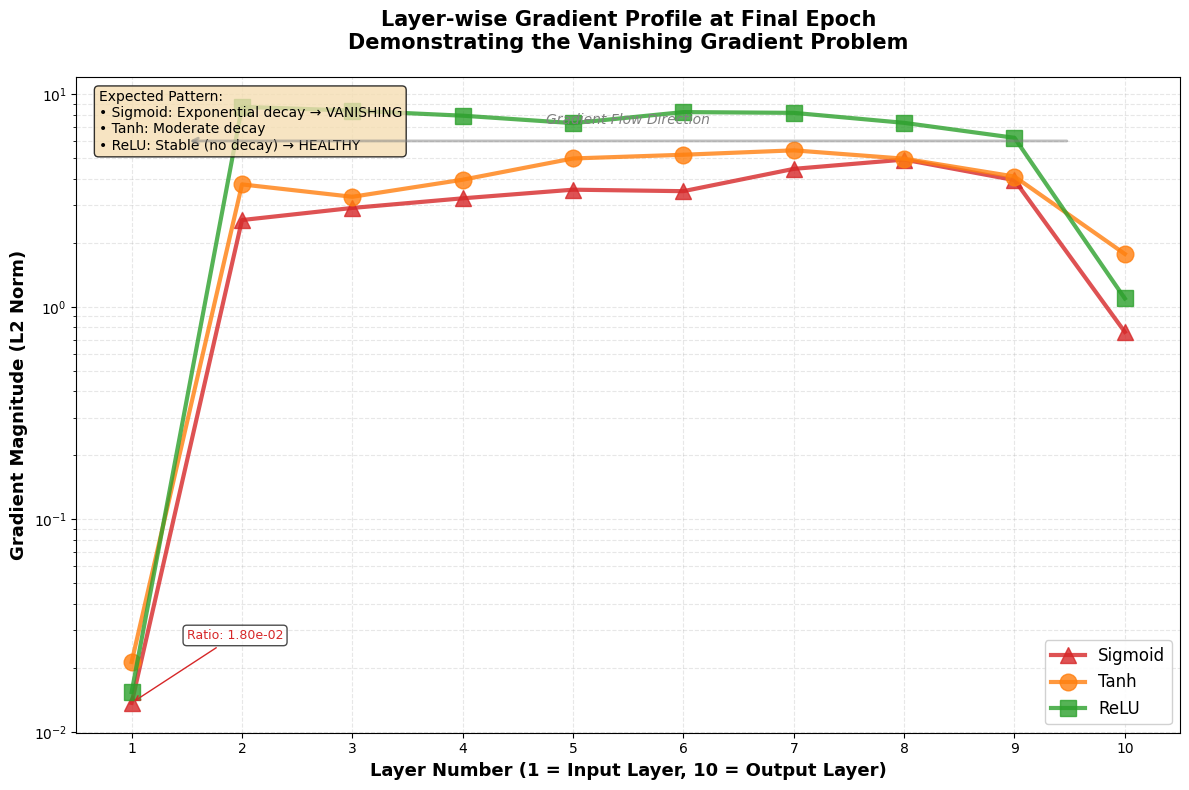


  Key Observation:
   - Sigmoid: Gradients vanish in early layers (red warning box)
   - Tanh: Moderate gradient flow
   - ReLU: Healthy gradient flow (green box)


In [6]:
print("\n[STEP 1.4] Visualizing gradient flow...")

example_model = MultiLayerPerceptron(architecture_deep, activation='relu')
plot_gradient_flow(
    gradient_histories, 
    example_model, 
    activations_to_test,
    save_name='vanishing_gradient_demo.png'
)

print("\n  Key Observation:")
print("   - Sigmoid: Gradients vanish in early layers (red warning box)")
print("   - Tanh: Moderate gradient flow")
print("   - ReLU: Healthy gradient flow (green box)")

## Step 1.5: Visualize Gradient Distributions

These plots show the **distribution** of signed gradient values across all training samples.

We'll create **3 separate plots** for first, middle, and last epochs.

**What to look for:**
- **Healthy**: Wide distribution symmetric around zero
- **Vanishing**: Distribution collapsed near zero

In [7]:
print("\n[STEP 1.5] Visualizing gradient norm distributions across epochs...")
print("Creating 3 separate plots: first epoch, middle epoch, last epoch\n")

plot_layer_gradient_norms(
    gradient_histories,
    example_model,
    activations_to_test,
    save_name='gradient_distributions',
    signed=False,
    remove_zero_gradients=False,
)

print("\n Key Observations:")
print("   First epoch: All activations show reasonable gradients")
print("   Last epoch: Sigmoid collapsed to ~0, ReLU still healthy!")

2026-02-23 23:58:50,259 | WARNING  | perceptron_to_DNN_tutorial.plotting:264 | Per-sample gradient distributions not found in history!
2026-02-23 23:58:50,260 | WARNING  | perceptron_to_DNN_tutorial.plotting:265 | Please train with track_per_sample_gradients=True



[STEP 1.5] Visualizing gradient norm distributions across epochs...
Creating 3 separate plots: first epoch, middle epoch, last epoch


 Key Observations:
   First epoch: All activations show reasonable gradients
   Last epoch: Sigmoid collapsed to ~0, ReLU still healthy!


## Step 1.6: Visualize Best Model (ReLU)

Let's see how well the ReLU model fits the data.


[STEP 1.6] Visualizing ReLU model fit...
2026-02-23 23:58:50,279 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-23 23:58:50,280 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-23 23:58:50,281 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: relu
2026-02-23 23:58:50,281 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.0
2026-02-23 23:58:50,282 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 132481
2026-02-23 23:58:50,282 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-23 23:58:50,283 | INFO     | perceptron_to_DNN_tutorial.train:505 | ======================================================================
2026-02-23 23:58:50,284 | INFO     | perceptron_to_DNN_tutorial.train:

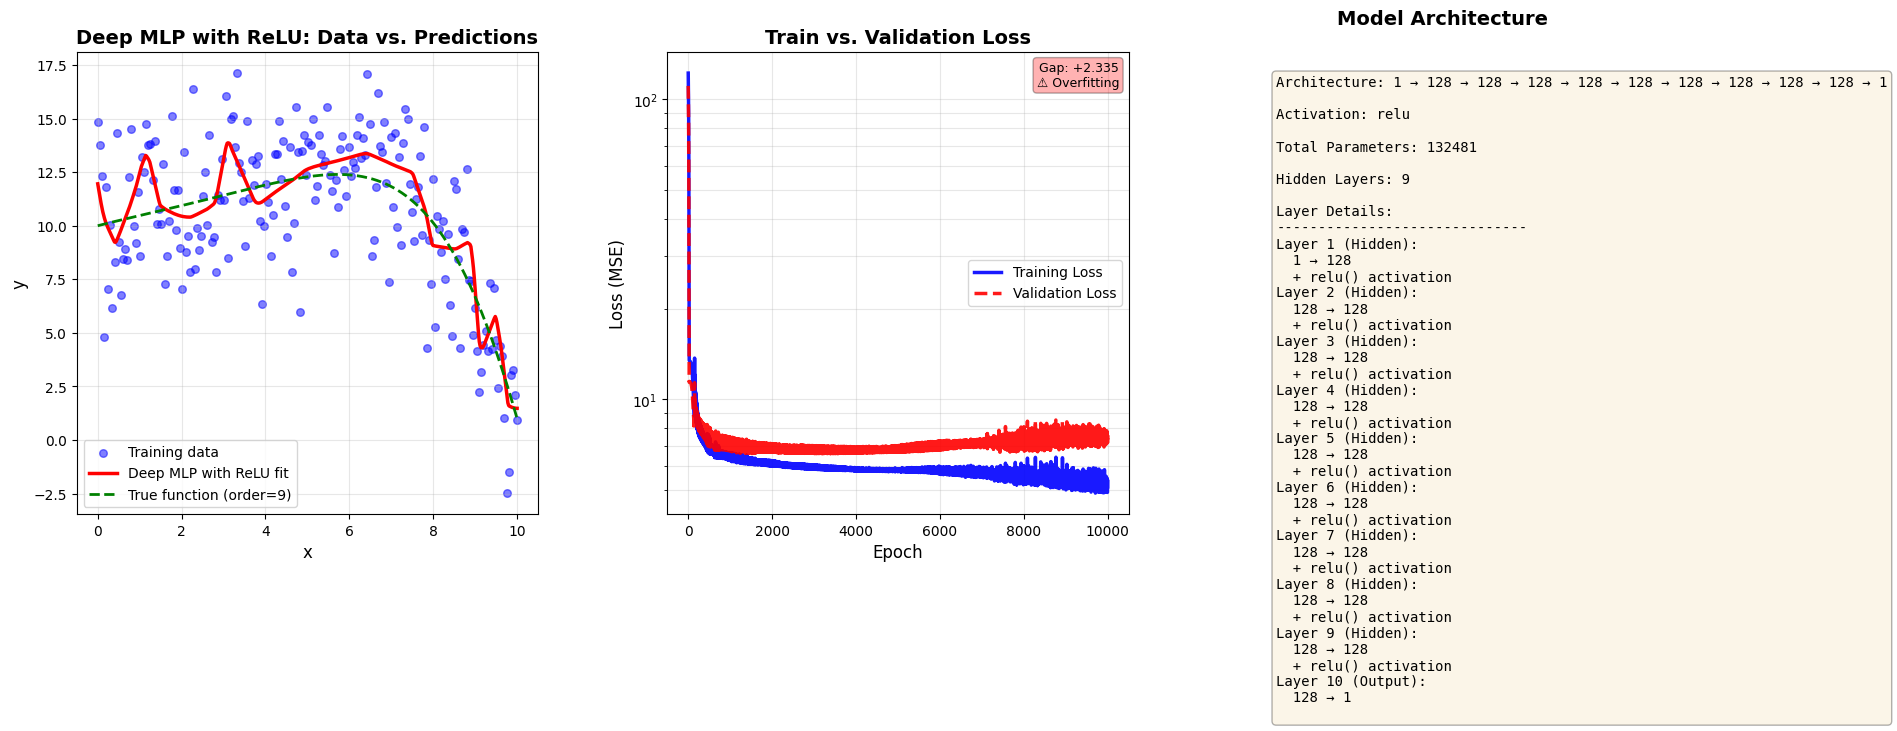

In [8]:
print("\n[STEP 1.6] Visualizing ReLU model fit...")

# Train a fresh ReLU model for visualization
relu_model = MultiLayerPerceptron(architecture_deep, activation='relu', dropout_rate=0.0)
relu_model, relu_history = train_model_with_gradient_tracking(
    model=relu_model,
    x_train=x_t,
    y_train=y_t,
    x_valid=x_valid_norm,
    y_valid=y_valid,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    reg_type='none',
    print_every=num_epochs + 1,  # Silent
    track_gradients=False  # Faster
)

# Visualize results
plot_results(
    x_t, y_t,
    relu_model,
    relu_history,
    coeffs_true,
    poly_order,
    model_name="Deep MLP with ReLU",
    normalizer=normalizer,
    show_validation=True
)

## Part 1 Summary

**What we learned:**

1. **Sigmoid and Tanh suffer from vanishing gradients** in deep networks
   - Gradients shrink exponentially through layers
   - Early layers barely learn

2. **ReLU solves the vanishing gradient problem**
   - ReLU'(x) = 1 for x > 0 (no gradient decay)
   - Gradients flow stably through all layers

3. **Gradient distributions reveal the problem**
   - Sigmoid: Distribution collapses near zero
   - ReLU: Distribution stays healthy

**Key takeaway:** For deep networks, **always use ReLU** (or variants like Leaky ReLU, ELU)!

---

# Part 2: Detecting Overfitting 

## What is overfitting?

Overfitting occurs when a model **memorizes** training data instead of learning the underlying pattern.

**Symptoms:**
- Training loss ↓↓↓ (keeps decreasing)
- Validation loss ↑ (starts increasing!)
- Large gap between train and validation loss

## How do we detect it?

By tracking **both** training and validation loss:
- **Good**: Both decrease together → generalization
- **Bad**: Train ↓, Valid ↑ → overfitting!

## Already Done! 

We actually already demonstrated overfitting detection in Part 1:
- Generated separate train/validation/test sets
- Tracked both training and validation loss
- Plots show the gap between train and validation curves

**Look at the previous plots:**
- The "Train vs. Validation Loss" panel shows both curves
- The gap between them indicates overfitting level
- Final gap is reported (e.g., "Gap: +0.7 Overfitting")

Now let's see how **regularization** can reduce overfitting!

---

# Part 3: Regularization Techniques

## What is regularization?

Regularization prevents overfitting by:
- Constraining model complexity
- Keeping weights small
- Adding controlled randomness

## Three techniques:

### 1. L1 Regularization (Lasso)
Adds penalty: $\lambda_1 \sum_i |w_i|$
- Promotes **sparse** weights (many → 0)
- Feature selection

### 2. L2 Regularization (Ridge/Weight Decay)
Adds penalty: $\lambda_2 \sum_i w_i^2$
- Keeps weights **small**
- Smooth solutions

### 3. Dropout
Randomly drops neurons during training:
- Prevents co-adaptation
- Ensemble-like behavior

Let's compare them!

## Step 3.1: Train WITH L1 Regularization

In [9]:
print("\n" + "="*70)
print(" PART 3: REGULARIZATION TECHNIQUES")
print("="*70)

print("\n[STEP 3.1] Training WITH L1 regularization...")

# Model without regularization
model_l1 = MultiLayerPerceptron(
    layer_sizes=architecture_deep,
    activation='relu',
    dropout_rate=0.0
)

# Train
_, history_l1 = train_model_with_validation_tracking(
    model=model_l1,
    x_train=x_t,
    y_train=y_t,
    x_valid=x_valid_norm,
    y_valid=y_valid,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    reg_type='l1',
    lambda_l1=lambda_l1,
    print_every=500,
    track_gradients=False  # Speed up training
)

print("\n L1 model trained!")


 PART 3: REGULARIZATION TECHNIQUES

[STEP 3.1] Training WITH L1 regularization...
2026-02-24 00:00:27,534 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-24 00:00:27,536 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-24 00:00:27,536 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: relu
2026-02-24 00:00:27,537 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.0
2026-02-24 00:00:27,537 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 132481
2026-02-24 00:00:27,538 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-24 00:00:27,539 | INFO     | perceptron_to_DNN_tutorial.train:783 | ======================================================================
2026-02-24 00:00:27,539 | INF

## Step 3.2: Train WITH L2 Regularization 

In [10]:
print("\n[STEP 3.2] Training WITH L2 regularization...")
print(f"L2 penalty: {lambda_l2}\n")

# Model with L2
model_l2 = MultiLayerPerceptron(
    layer_sizes=architecture_deep,
    activation='relu',
    dropout_rate=0.0
)

# Train with L2
_, history_l2 = train_model_with_validation_tracking(
    model=model_l2,
    x_train=x_t,
    y_train=y_t,
    x_valid=x_valid_norm,
    y_valid=y_valid,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    reg_type='l2',
    lambda_l2=lambda_l2,
    print_every=500,
    track_gradients=False
)

print("\n L2 regularized model trained!")


[STEP 3.2] Training WITH L2 regularization...
L2 penalty: 0.01

2026-02-24 00:02:27,851 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-24 00:02:27,852 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-24 00:02:27,854 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: relu
2026-02-24 00:02:27,854 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.0
2026-02-24 00:02:27,855 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 132481
2026-02-24 00:02:27,856 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-24 00:02:27,857 | INFO     | perceptron_to_DNN_tutorial.train:783 | ======================================================================
2026-02-24 00:02:27,858 | INFO     | perceptron

## Step 3.3: Train WITH Dropout 

In [11]:
print("\n[STEP 3.3] Training WITH dropout...")
print(f"Dropout rate: {dropout_rate}\n")

# Model with dropout
model_dropout = MultiLayerPerceptron(
    layer_sizes=architecture_deep,
    activation='relu',
    dropout_rate=dropout_rate
)

# Train
_, history_dropout = train_model_with_validation_tracking(
    model=model_dropout,
    x_train=x_t,
    y_train=y_t,
    x_valid=x_valid_norm,
    y_valid=y_valid,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    reg_type='none',
    print_every=500,
    track_gradients=False
)

print("\n Dropout model trained!")


[STEP 3.3] Training WITH dropout...
Dropout rate: 0.1

2026-02-24 00:04:26,723 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:250 | Initialized MultiLayerPerceptron:
2026-02-24 00:04:26,724 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:251 |   Architecture: 1 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 128 → 1
2026-02-24 00:04:26,724 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:252 |   Activation: relu
2026-02-24 00:04:26,725 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:253 |   Dropout rate: 0.1
2026-02-24 00:04:26,725 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:254 |   Total parameters: 132481
2026-02-24 00:04:26,726 | INFO     | perceptron_to_DNN_tutorial.MultiLayerPerceptron:255 |   Hidden layers: 9
2026-02-24 00:04:26,728 | INFO     | perceptron_to_DNN_tutorial.train:783 | ======================================================================
2026-02-24 00:04:26,729 | INFO     | perceptron_to_DNN_t

## Step 3.4: Compare Regularization Methods 

Now let's visualize all three approaches side-by-side!

In [12]:
#print("\n[STEP 3.4] Comparing regularization methods...\n")

# Compare all methods
#plot_regularization_comparison(
#    histories=[history_no_reg, history_l2, history_dropout],
#    model_names=['No Regularization', 'L2 Regularization', f'Dropout (p={dropout_rate})'],
#    save_name='regularization_comparison.png'
#)

#print("\n Key Observations:")
#print("   - No regularization: Larger train-validation gap")
#print("   - L2: Smaller gap, smoother training")
#print("   - Dropout: Smaller gap, more stable")
#print("\n   Regularization keeps validation loss close to training loss!")

## Step 3.5: Visualize Dropout Model 


[STEP 3.5] Visualizing dropout model fit...
2026-02-24 00:06:47,523 | INFO     | perceptron_to_DNN_tutorial.plotting:751 | Results plot saved as 'deep_mlp_with_no_reg._results.png'


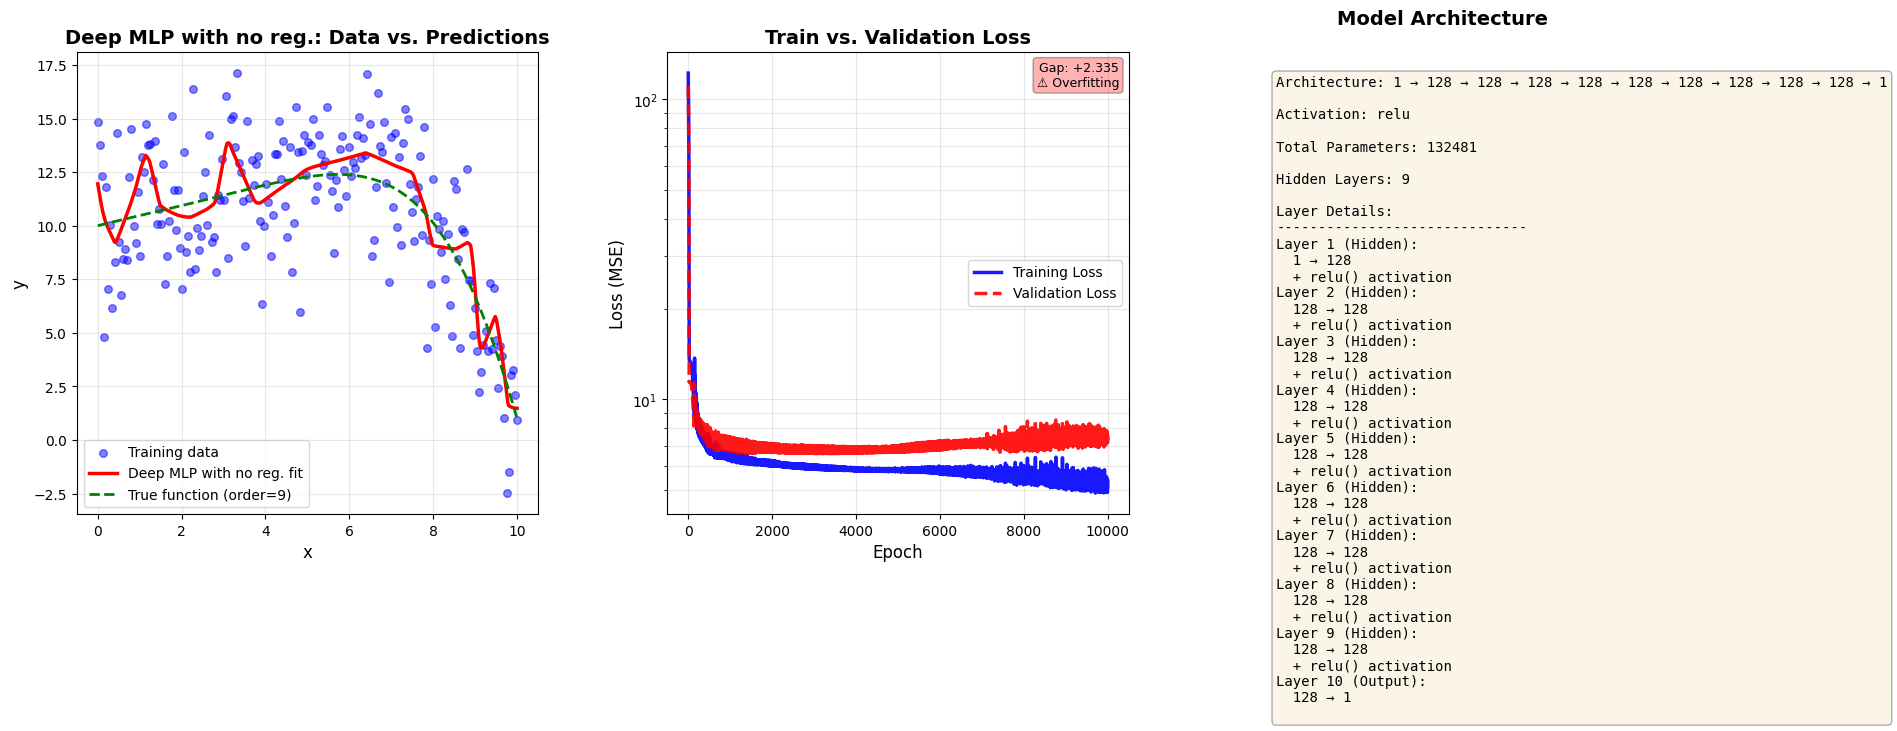

2026-02-24 00:06:48,365 | INFO     | perceptron_to_DNN_tutorial.plotting:751 | Results plot saved as 'deep_mlp_with_l1_(l1=0.001)._results.png'


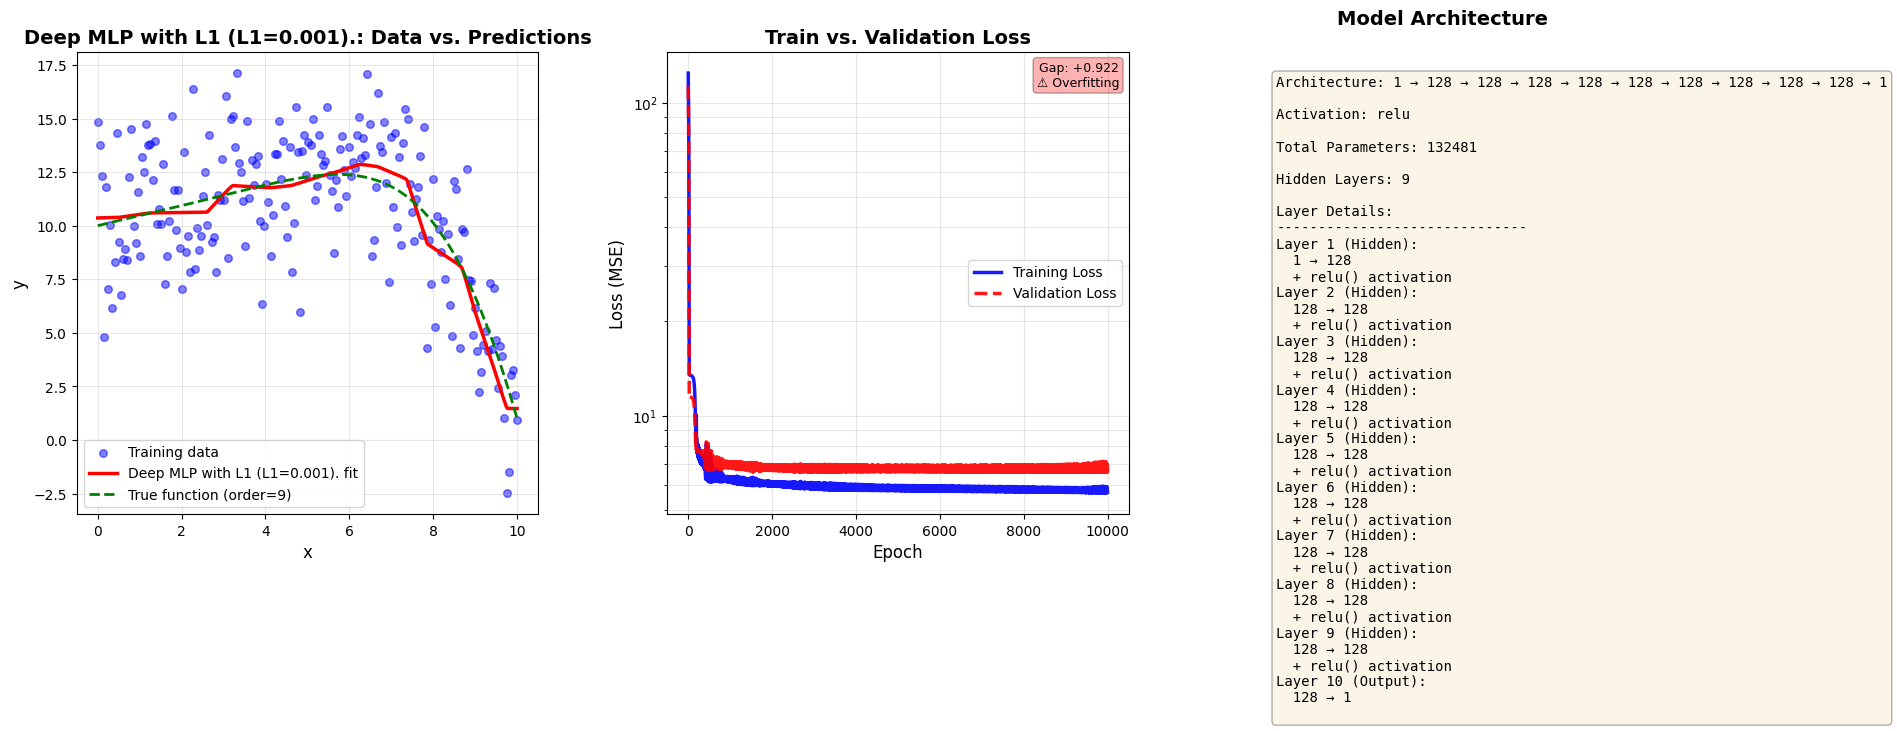

2026-02-24 00:06:49,151 | INFO     | perceptron_to_DNN_tutorial.plotting:751 | Results plot saved as 'deep_mlp_with_l2_(l2=0.01)_results.png'


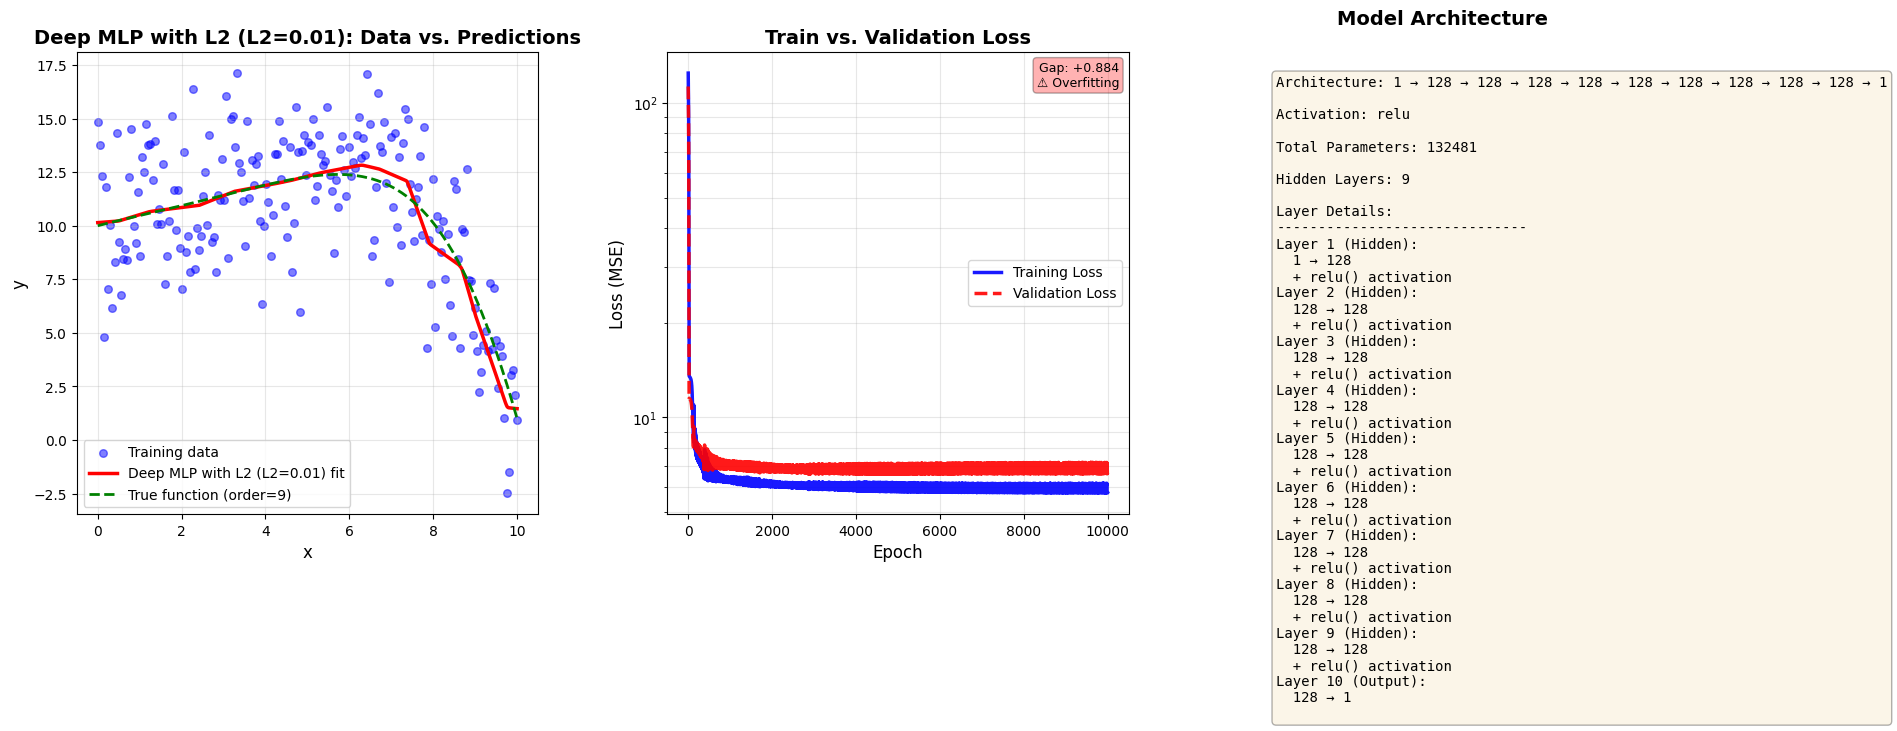

2026-02-24 00:06:49,995 | INFO     | perceptron_to_DNN_tutorial.plotting:751 | Results plot saved as 'deep_mlp_with_dropout_(p=0.1)_results.png'


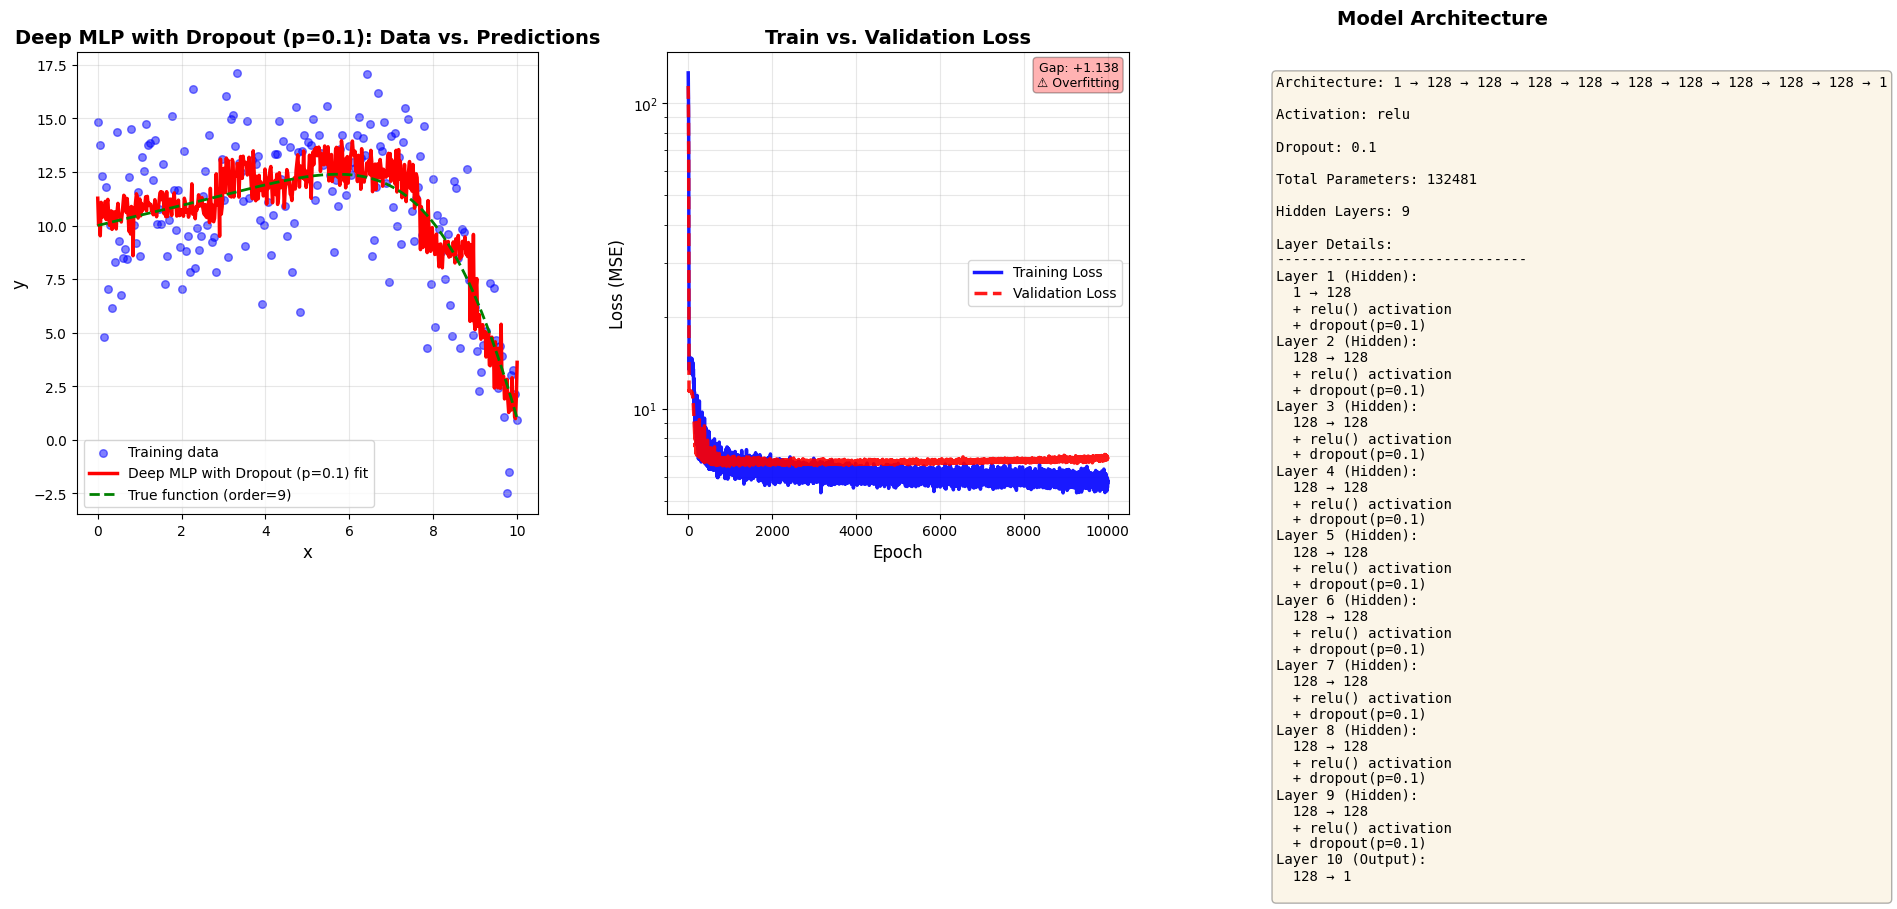

In [13]:
print("\n[STEP 3.5] Visualizing dropout model fit...")

plot_results(
    x_t, y_t,
    relu_model,
    relu_history,
    coeffs_true,
    poly_order,
    model_name=f"Deep MLP with no reg.",
    normalizer=normalizer,
    show_validation=True
)


plot_results(
    x_t, y_t,
    model_l1,
    history_l1,
    coeffs_true,
    poly_order,
    model_name=f"Deep MLP with L1 (L1={lambda_l1}).",
    normalizer=normalizer,
    show_validation=True
)

plot_results(
    x_t, y_t,
    model_l2,
    history_l2,
    coeffs_true,
    poly_order,
    model_name=f"Deep MLP with L2 (L2={lambda_l2})",
    normalizer=normalizer,
    show_validation=True
)

plot_results(
    x_t, y_t,
    model_dropout,
    history_dropout,
    coeffs_true,
    poly_order,
    model_name=f"Deep MLP with Dropout (p={dropout_rate})",
    normalizer=normalizer,
    show_validation=True
)

## Part 3 Summary

**What we learned:**

1.  **Without regularization**: Models can overfit
   - Training loss keeps decreasing
   - Validation loss plateaus or increases
   - Large train-validation gap

2.  **L2 regularization**: Keeps weights small
   - Adds penalty: $\lambda_2 \sum w_i^2$
   - Reduces overfitting
   - Smoother training curves

3.  **Dropout**: Random neuron deactivation
   - Prevents co-adaptation
   - Acts like ensemble learning
   - Very effective regularization

**Key takeaway:** Always use regularization for better generalization!

**Recommended approach:**
- Start with L2 regularization (λ ≈ 0.01)
- Add dropout (p ≈ 0.2-0.3) for extra robustness
- Monitor train-validation gap to tune hyperparameters

---

#  Tutorial Complete!

## Congratulations! 

You've mastered the fundamentals of deep neural networks:

### What you learned:

1. **Vanishing Gradients**
   - Why sigmoid/tanh fail in deep networks
   - How ReLU solves the problem
   - Gradient flow visualization

2. **Overfitting Detection**
   - Train/validation/test splits
   - Monitoring train-validation gap
   - Identifying memorization vs learning

3. **Regularization**
   - L2 regularization (weight decay)
   - Dropout (random deactivation)
   - Preventing overfitting

###  Experiments to Try:

1. **Change network depth**: Try 5 layers vs 15 layers
2. **Modify data complexity**: Change `poly_order` to 5 or 15
3. **Tune regularization**: Try different λ values (0.001, 0.1, 1.0)
4. **Compare learning rates**: Test [0.001, 0.01, 0.1]
5. **Add a skip connection between the layers**

###  Next Steps:

- **Tutorial 3**: [From DNNs to Transformers](../docs/tutorials/tutorial-3.md)

###  Key Principles to Remember:

1. **Always use ReLU** (or variants) for deep networks
2. **Always split data** into train/val/test
3. **Always monitor validation loss** to detect overfitting
4. **Always use regularization** (L2 + dropout is a good default)
5. **Always normalize inputs** before training

---

##  Questions?

- Check the [FAQ](../docs/faq.md)
- See [Troubleshooting](../docs/troubleshooting.md)
- Open an issue on GitHub

Happy learning! 